# Машинное обучение в бизнесе
## Урок 1. Кейс 1. EDA по Hourly Energy Consumption и Brent

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

# Задание 1

Выберите наборы данных. которые можно интерпретировать, как временные ряды:

    а) зависимость цены на недвижимость в конкретном регионе от времени,
    б) скорость полета самолета при перелете из аэропорта А в аэропорт В,
    в) количество отказов компьютера,
    г) число обращений в поликлинику по району,
    д) координаты автобуса при движении по маршруту,
    е) координаты фигуры нарушителя в файле видеофиксации охранной системы.

**Решение**

а, б, д

# Задание 2

Прочитайте `DUQ_hourly.csv` и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.

**Решение**

In [3]:
duq = pd.read_csv('DUQ_hourly.csv', index_col=[0], parse_dates=[0]).sort_index()
display(duq.info())
duq.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119068 entries, 2005-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
DUQ_MW    119068 non-null float64
dtypes: float64(1)
memory usage: 1.8 MB


None

,DUQ_MW
Datetime,
2005-01-01 01:00:00,1364.0
2005-01-01 02:00:00,1273.0
2005-01-01 03:00:00,1218.0


Результат анализа типов показывает, что интервал изменения индексов начинается от `2005-01-01 01:00:00` и идет до `2018-08-03 00:00:00`. Шаг измерений по времени составляет $1$ час. Общий объем данных составляет $119068$ значений, а тип измеряемой информации при записи был определен как `float64`.

Проверим полноту данных:

In [4]:
first_measure_date = duq.index.values.min()
last_measure_date = duq.index.values.max()
all_dates = np.arange(first_measure_date.astype('datetime64[h]'), last_measure_date.astype('datetime64[h]') + 1)
len(all_dates) - len(duq)

20

Не хватает $20$ значений. Найдём их.

In [5]:
mask = np.isin(all_dates, duq.index)
missed = all_dates[~mask]

print('Всего:', len(missed))
pd.Series(missed).value_counts().sort_index()

Всего: 24


2005-04-03 03:00:00    1
2005-10-30 02:00:00    1
2006-04-02 03:00:00    1
2006-10-29 02:00:00    1
2007-03-11 03:00:00    1
2007-11-04 02:00:00    1
2008-03-09 03:00:00    1
2008-11-02 02:00:00    1
2009-03-08 03:00:00    1
2009-11-01 02:00:00    1
2010-03-14 03:00:00    1
2010-11-07 02:00:00    1
2010-12-10 00:00:00    1
2011-03-13 03:00:00    1
2011-11-06 02:00:00    1
2012-03-11 03:00:00    1
2012-11-04 02:00:00    1
2013-03-10 03:00:00    1
2013-11-03 02:00:00    1
2014-03-09 03:00:00    1
2015-03-08 03:00:00    1
2016-03-13 03:00:00    1
2017-03-12 03:00:00    1
2018-03-11 03:00:00    1
dtype: int64

- Каждый год до 2014 мы наблюдаем по 2 пропуска (в 2010 их 3) в одно и то же время и примерно одинаковые даты, можем предположить, что это связано с переводом времени на зимнее/летнее
- Пропусков на 4 больше, чем предпологали. Значит в датасете имеются не только пропущенные значения, но и дублирующиеся. Либо данные не за час, а за более короткий промежуток времени.

Проверим:

In [6]:
duq.index.value_counts()[lambda v: v > 1].sort_index()

2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2017-11-05 02:00:00    2
Name: Datetime, dtype: int64

Нашли 4 дублирующихся даты, начиная с 2014 года. Можно сделать предположение, что дублирование измерений происходит в момент перевода времени на час назад. Посмотрим на декабрь 2010 в целом, и на 9-10 декабря подробнее:

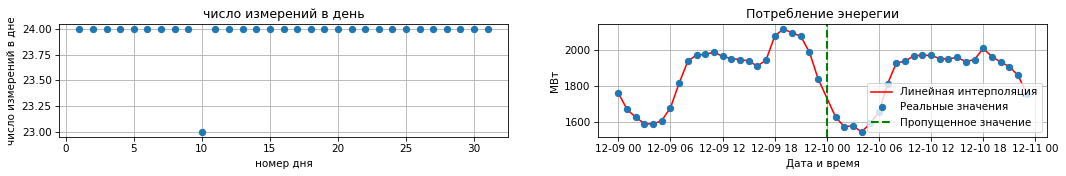

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 2), dpi=75)

duq_2010_12 = duq['2010-12-01 00:00:00':'2010-12-31 23:00:00'].index.day
ax1.plot(duq_2010_12.value_counts().index, duq_2010_12.value_counts().values, 'o')
ax1.set_xlabel('номер дня')
ax1.set_ylabel('число измерений в дне')
ax1.set_title('число измерений в день')
ax1.grid()

duq_2010_12_10 = duq['2010-12-09 00:00:00':'2010-12-10 23:00:00']
ax2.plot(duq_2010_12_10, 'r', label='Линейная интерполяция')
ax2.plot(duq_2010_12_10, 'o', label='Реальные значения')
ax2.axvline(np.datetime64('2010-12-10T00:00:00'), linewidth=2, color='g', ls='--', label='Пропущенное значение')
ax2.legend()
ax2.set_xlabel('Дата и время')
ax2.set_ylabel('МВт')
ax2.set_title('Потребление энерегии')
ax2.grid()

plt.show()

Заполним значения пропущенных полей средним двух соседних точек

In [8]:
interpolated = pd.Series(data=[(duq.loc[dt-1]['DUQ_MW']+duq.loc[dt+1]['DUQ_MW'])/2 for dt in missed], index=missed, name='DUQ_MW')
duq = duq.append(pd.DataFrame(interpolated))

Уберем лишние точки (дублирование метки в индексах)

In [9]:
duq = duq.groupby(level=0).mean()

Проверим внесенные изменения

In [10]:
print(len(duq) == len(all_dates))
print(len(duq.index.value_counts()[lambda v: v > 1]) == 0)

True
True


Отсортируем значения

In [11]:
duq = duq.sort_index()

Посмотрим на графики:

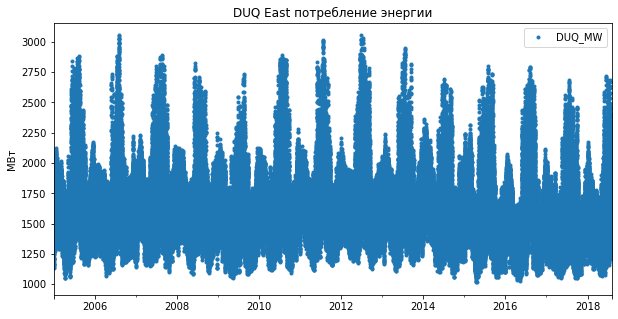

In [12]:
duq.plot(style='.', figsize=(10, 5), title='DUQ East потребление энергии')
plt.ylabel('МВт')
plt.show()

- Основные статистики показали, что пропусков нет
- Визуальный анализ показывает, что:
    - предъявленные данные имеют годовые периоды
    - после 2014 года наблюдаем спад потребления
    
Рассмотрим годовой период:

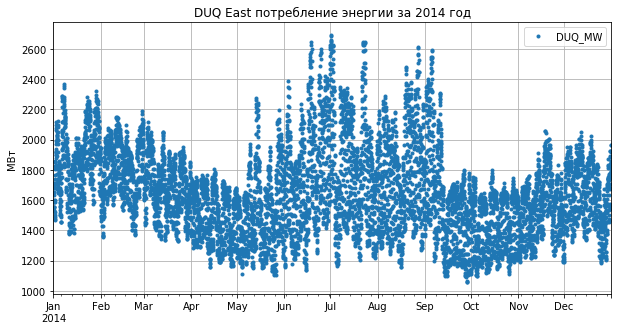

In [13]:
duq_2014 = duq.loc[lambda df: df.index.year == 2014, :].sort_index()
duq_2014.plot(style='.', figsize=(10, 5), title='DUQ East потребление энергии за 2014 год')
plt.ylabel('МВт')
plt.grid()
plt.show()

Видим, что наибольшее потребление электроэнергии приходится в период наибольшей солнечной активности, с конца мая до середины сентября, и в зимний период, с середины ноября до середины марта. Демисезон отличается наименьшей активностью электропотребителей (апрель-март и сентябрь-ноябрь).

Кроме того, наблюдаем месячные период. Рассмотрим один из них:

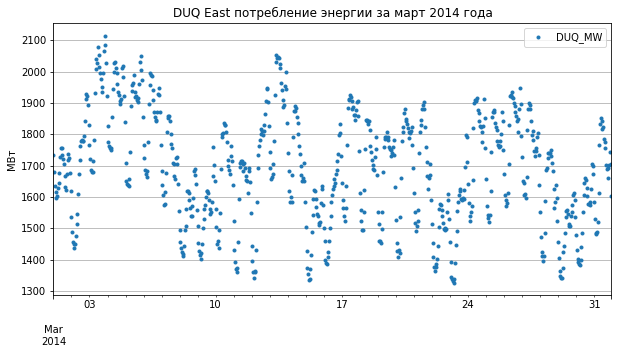

In [14]:
duq_2014_03 = duq.loc[lambda df: (df.index.year == 2014) & (df.index.month == 3), :].sort_index()
duq_2014_03.plot(style='.', figsize=(10, 5), title='DUQ East потребление энергии за март 2014 года')
plt.ylabel('МВт')
plt.grid()
plt.show()

Наблюдаем недельные периоды повышенной и пониженной активности. Очевидно, что они связаны с выходными, которые приходились на $1, 2, 8, 9, 15, 16, 22, 23, 29, 30$ числа этого месяца.

Рассмотрим дневной период:

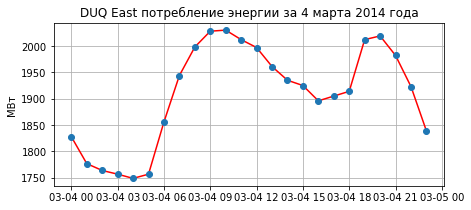

In [15]:
duq_2014_03_04 = duq.loc[lambda df: (df.index.year == 2014) & (df.index.month == 3) & (df.index.day == 4), :].sort_index()
plt.figure(figsize=(7,3))
plt.plot(duq_2014_03_04, 'r')
plt.plot(duq_2014_03_04, 'o')
plt.title('DUQ East потребление энергии за 4 марта 2014 года')
plt.ylabel('МВт')
plt.grid()
plt.show()

- пониженная активность в ночное время с 00:00 до 6:00
- повышенная активность в рабочие часы с 8:00 до 15:00
- средняя активность с 15:00 до 18:00
- повышенная активность в вечернее время с 19:00 до 22:00

In [16]:
## отчёт новых знаний не дал
# pandas_profiling.ProfileReport(duq)

# Задание 3

Прочитайте базу Brent и сделайте ее перерасчет (ресемплинг) в представление по неделям , по месяцам.

**Решение**

In [17]:
brent = pd.read_excel('brand.xlsx', names=['date', 'cost'], index_col=[0], parse_dates=[0]).sort_index()

In [18]:
brent_weekly = brent.resample('W').mean().sort_index()

In [19]:
brent_monthly = brent.resample('M').mean().sort_index()

# Задание 4

Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent.

**Решение**

In [24]:
brent

,cost
date,
2010-09-01,76.37
2010-09-02,76.89
2010-09-03,76.57
2010-09-04,76.62
2010-09-05,76.63
...,...
2019-08-27,59.59
2019-08-28,59.84
2019-08-29,60.37


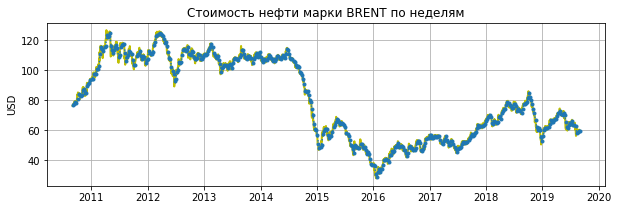

In [259]:
plt.figure(figsize=(10, 3))
plt.plot(brent.index, brent.cost, 'y-', linewidth=2)
plt.plot(brent_weekly.index, brent_weekly.cost, '.:')
plt.title('Стоимость нефти марки BRENT по неделям')
plt.ylabel('USD')
plt.grid()
plt.show()

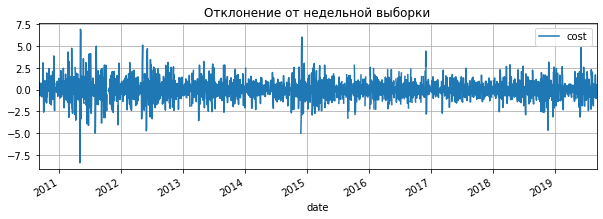

In [77]:
brent_weekly_b = brent.copy().loc[lambda df: ~df.index.isin(brent_weekly.index)]
brent_weekly_b.cost = None
brent_weekly_b = brent_weekly_b.append(brent_weekly).sort_index().bfill()
brent_weekly_b = brent_weekly_b - brent
brent_weekly_b.plot(figsize=(10, 3), title='Отклонение от недельной выборки', grid=True)
plt.show()

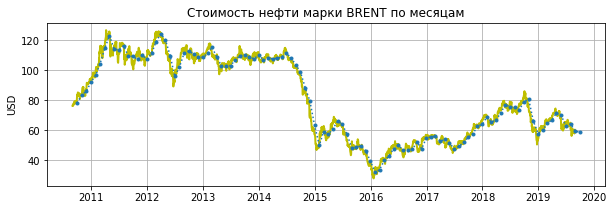

In [81]:
plt.figure(figsize=(10, 3))
plt.plot(brent.index, brent.cost, 'y-', linewidth=2)
plt.plot(brent_monthly.index, brent_monthly.cost, '.:')
plt.title('Стоимость нефти марки BRENT по месяцам')
plt.ylabel('USD')
plt.grid()
plt.show()

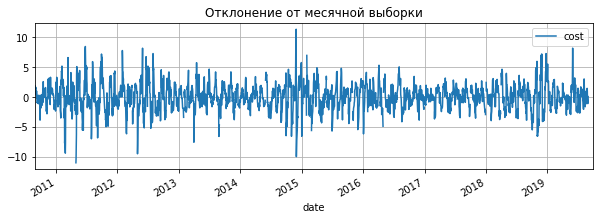

In [82]:
brent_monthly_b = brent.copy().loc[lambda df: ~df.index.isin(brent_monthly.index)]
brent_monthly_b.cost = None
brent_monthly_b = brent_monthly_b.append(brent_monthly).sort_index().bfill()
brent_monthly_b = brent_monthly_b - brent
brent_monthly_b.plot(figsize=(10, 3), title='Отклонение от месячной выборки', grid=True)
plt.show()

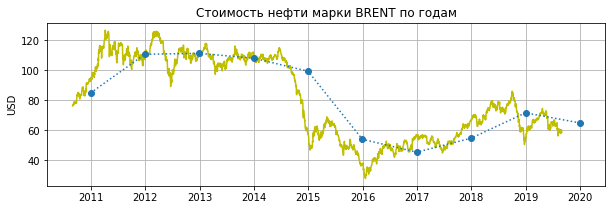

In [83]:
brent_yearly = brent.resample('Y').mean().sort_index()

plt.figure(figsize=(10, 3))
plt.plot(brent.index, brent.cost, 'y-')
plt.plot(brent_yearly.index, brent_yearly.cost, 'o:')
plt.title('Стоимость нефти марки BRENT по годам')
plt.ylabel('USD')
plt.grid()
plt.show()

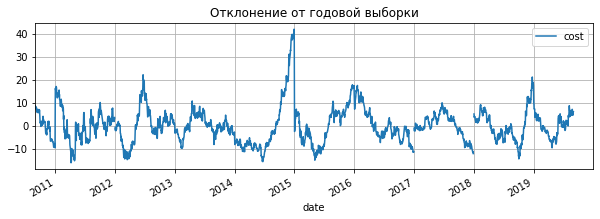

In [84]:
brent_yearly_b = brent.copy().loc[lambda df: ~df.index.isin(brent_yearly.index)]
brent_yearly_b.cost = None
brent_yearly_b = brent_yearly_b.append(brent_yearly).sort_index().bfill()
brent_yearly_b = brent_yearly_b - brent
brent_yearly_b.plot(figsize=(10, 3), title='Отклонение от годовой выборки', grid=True)
plt.show()

# Задание 5

Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с дневными.

**Решение**

Графики сгладились, при этом тренды не изменились.